# Modelling with Neural Networks

In this notebook, I use several neural networks to try and get a better prediction of solar energy potential. 

**Contents:**
- [Import libraries and data](#Import-libraries-and-data) 
- [Preprocessing](#Preprocessing)
- [Evaluation metric](#Evaluation-Metric)
- [Modelling with Recurrent Neural Networks (RNN)](#Modelling-with-Recurrent-Neural-Networks-(RNN))
- [Modelling with Long Short-Term Memory Network (LSTM)](#Modelling-with-Long-Short-Term-Memory-Network-(LSTM))
- [Conclusion](#Conclusion)
- [References](#References)

### Import libraries and data

In [2]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
plt.style.use('seaborn-white')
import seaborn as sns
from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
import time
#for modelling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, Dropout, LSTM, GRU
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
#read data
spain_ep_nuts = pd.read_csv("../data/spain-energy-potential-nuts.csv")
#preview
print(' Top 5 rows '.center(50,'-'))
display(spain_ep_nuts.head())
print(f'Shape of data : {spain_ep_nuts.shape}')
print(' Data types '.center(50,'-'))
print(spain_ep_nuts.dtypes)

------------------- Top 5 rows -------------------


,ES11,ES12,ES13,ES21,ES22,ES23,ES24,ES30,ES41,ES42,ES43,ES51,ES52,ES53,ES61,ES62,time,hour,week,month
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2006-01-03 00:00:00,0,1,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2006-01-03 01:00:00,1,1,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2006-01-03 02:00:00,2,1,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2006-01-03 03:00:00,3,1,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2006-01-03 04:00:00,4,1,1


Shape of data : (87600, 20)
------------------- Data types -------------------
ES11     float64
ES12     float64
ES13     float64
ES21     float64
ES22     float64
ES23     float64
ES24     float64
ES30     float64
ES41     float64
ES42     float64
ES43     float64
ES51     float64
ES52     float64
ES53     float64
ES61     float64
ES62     float64
time      object
hour       int64
week       int64
month      int64
dtype: object


### Preprocessing 

This time, we predict the energy potential based on past 2 days' (48 hours') worth of data of region efficiencies, as opposed to merely based on time data.

In [4]:
#drop time columns
spain_ep_nuts.drop(columns=['time','hour','week','month'], inplace=True)

In [5]:
#prep features with 48hours lagged data
def prep_features(df, lag_hours):
    X = []
    for i in range(len(df)-lag_hours-1):
        X.append(df.iloc[i:i+lag_hours].values)
    return np.array(X)
#set lag for 48hours prior
lag_hours = 48
# set the target variable and the features
y = spain_ep_nuts['ES11'][lag_hours+1:]
X = prep_features(spain_ep_nuts, lag_hours)

In [6]:
#check shape of data 
print(f"Shape of X : {X.shape}")
print(f"Shape of y : {y.shape}")

Shape of X : (87551, 48, 16)
Shape of y : (87551,)


In [7]:
#train-test-split, test set as the last month for predictions (12-2015)
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X, 
                                                                    y, 
                                                                    test_size=0.2, 
                                                                    random_state=0,
                                                                    shuffle=False) # ensure that test size is the last portion

### Evaluation Metric

In [8]:
#function that computes rmse
def rmse(y_true, y_pred):
    rmse = round(np.sqrt(mean_squared_error(y_true, y_pred)),4)
    return rmse

In [9]:
#function that computes mae
def mae(y_true, y_pred):
    mae = round(mean_absolute_error(y_true, y_pred),4)
    return mae

### Modelling with Recurrent Neural Networks (RNN)

RNN is like a feedforward neural network just that it has connections pointing backwards. 

RNNs suffer from **vanishing gradient problem** which hinder them from using long term information. They are good for storing memory 3-4 instances of past iterations but larger number of instances don't provide good results. 

In [10]:
#build RNN
def rnn():
    rnn = Sequential()
    rnn.add(SimpleRNN(units=32,
                     return_sequences=True,
                     input_shape=(lag_hours,16)))
    rnn.add(SimpleRNN(units=32,
                     return_sequences=True))
    rnn.add(SimpleRNN(units=32,
                     return_sequences=False))
    rnn.add(Dense(units=1,
                 activation='linear'))
    return rnn

In [11]:
%%time
rnn_model = rnn()
rnn_model.compile(optimizer='adam',
                 loss='mean_squared_error')
rnn_model.fit(x=X_train_rnn,
             y=y_train_rnn,
             validation_data = (X_test_rnn, y_test_rnn),
             epochs=30,
             batch_size=64)

Epoch 1/30
1095/1095 [==============================] - 12s 9ms/step - loss: 0.0142 - val_loss: 0.0032
Epoch 2/30
1095/1095 [==============================] - 9s 8ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 3/30
1095/1095 [==============================] - 9s 9ms/step - loss: 0.0027 - val_loss: 0.0040
Epoch 4/30
1095/1095 [==============================] - 9s 9ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 5/30
1095/1095 [==============================] - 9s 9ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 6/30
1095/1095 [==============================] - 9s 9ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 7/30
1095/1095 [==============================] - 9s 9ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 8/30
1095/1095 [==============================] - 10s 9ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 9/30
1095/1095 [==============================] - 9s 9ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 10/30
1095/1095 [==============================] - 9s 9ms/step - loss: 0.0

A simple RNN works much better than any of the above algorithms. 

In [12]:
#load the results from past ML algos. 
results = open("../data/results_train.txt","r")
results_train = results.read()
print(results_train)

+----------------------------------------------+
|  Results of Forecasting Models on Train Set  |
+------------------------+----------+----------+
|         Model          |   Rmse   |   Mae    |
+------------------------+----------+----------+
|        Baseline        |  0.0524  |  0.0258  |
|   Linear Regression    |  0.0532  |  0.0283  |
|     Random Forest      |  0.0542  |  0.0268  |
|      K Neighbors       |  0.0622  |  0.0313  |
|          XGB           |  0.0554  |  0.0346  |
|       FB Prophet       |  0.0491  |  0.0293  |
+------------------------+----------+----------+


In [13]:
#make predictions with rnn model 
y_pred_train_rnn, y_pred_test_rnn = rnn_model.predict(X_train_rnn), rnn_model.predict(X_test_rnn)
rmse_train_rnn = rmse(y_train_rnn, y_pred_train_rnn)
mae_train_rnn = mae(y_train_rnn, y_pred_train_rnn)
#add to results table
results_train = PrettyTable(title = "Results of Forecasting Models on Train Set", header_style = 'title', max_table_width = 130)
results_train.field_names = ["Model", "RMSE", "MAE"]
results_train.add_row(["Baseline",0.0524,0.0258])
results_train.add_row(["Linear Regression",0.0532,0.0283])
results_train.add_row(["Random Forest",0.0542,0.0268])
results_train.add_row(["K Neighbors",0.0622,0.0313])
results_train.add_row(["XGB",0.0554,0.0346])
results_train.add_row(["FB Prophet",0.0491,0.0293])
results_train.add_row(["RNN",rmse_train_rnn,mae_train_rnn])

In [14]:
#view results
print(results_train)

+----------------------------------------------+
|  Results of Forecasting Models on Train Set  |
+------------------------+----------+----------+
|         Model          |   Rmse   |   Mae    |
+------------------------+----------+----------+
|        Baseline        |  0.0524  |  0.0258  |
|   Linear Regression    |  0.0532  |  0.0283  |
|     Random Forest      |  0.0542  |  0.0268  |
|      K Neighbors       |  0.0622  |  0.0313  |
|          XGB           |  0.0554  |  0.0346  |
|       FB Prophet       |  0.0491  |  0.0293  |
|          RNN           |  0.0381  |  0.0197  |
+------------------------+----------+----------+


RNN did much better that other models before, including better than fbprophet. 

In [15]:
#function that plots prediction on test set
def predictions_viz(df, title):
    plt.figure(figsize=(20,8))
    sns.lineplot(data=df, palette='inferno_r')
    plt.title(title, fontsize=16)
    plt.xlabel("December 2015 (hours)", fontsize=14)
    plt.xticks([])
    plt.ylabel("Energy potential (%)", fontsize=14)
    plt.legend(labels=['true values', 'predictions'], fontsize=14)
    plt.show()

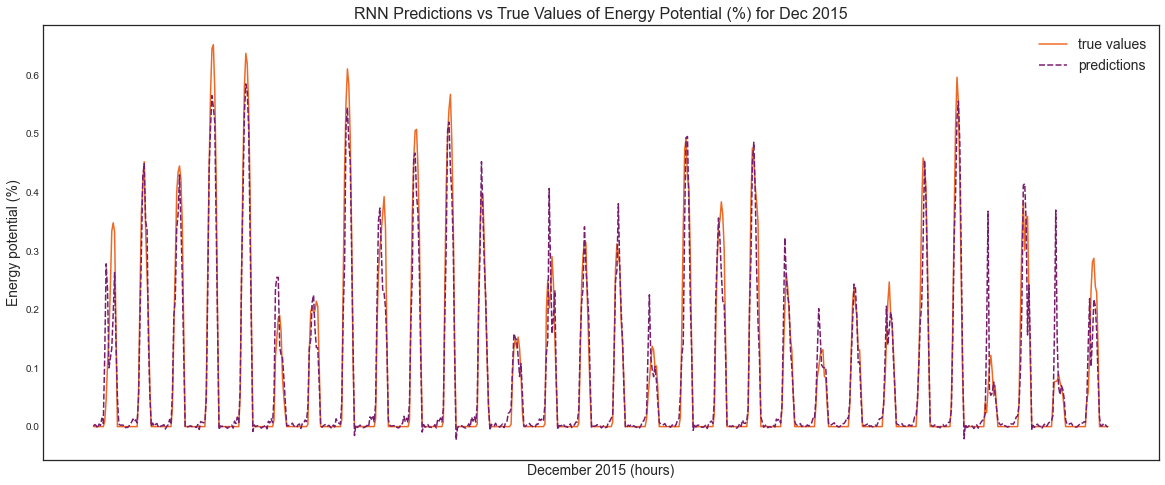

In [17]:
#create dataframe for visualization
rnn_viz = pd.DataFrame(zip(list(y_test_rnn), list(np.squeeze(y_pred_test_rnn))), columns = ['true values', 'prediction'])
# visualise
predictions_viz(rnn_viz[-30*24:],"RNN Predictions vs True Values of Energy Potential (%) for Dec 2015")

From here we see much more improvement from fbprophet. The model was able to predict more accurately the daily solar energy potential. 

### Modelling with Long Short-Term Memory Network (LSTM)

LSTM is an RNN that is trained using Backpropagation Through Time. Instead of neuronsm LSTM networks have memory blocks that are connected through layers. 

A block has components that make it smarter than a classical neuron, and a memory for recent sequences. 

In [18]:
# create function to run lstm
def lstm(input_shape):
    lstm = Sequential()
    lstm.add(LSTM(units=32,
                 return_sequences=True,
                 activation='relu',
                 input_shape=input_shape))
    lstm.add(LSTM(units=32,
                 activation='relu',
                 return_sequences=False))
    lstm.add(Dense(units=1, activation='linear'))
    return lstm

In [21]:
lstm_model = lstm(X.shape[1:])
lstm_model.compile(optimizer='adam',
                   loss='mean_squared_error')
lstm_model.fit(x=X_train_rnn,
              y=y_train_rnn,
              validation_data=(X_test_rnn, y_test_rnn),
              epochs=30,
              batch_size=32)

Epoch 1/50
2189/2189 [==============================] - 28s 12ms/step - loss: 0.0121 - val_loss: 0.0024
Epoch 2/50
2189/2189 [==============================] - 25s 11ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 3/50
2189/2189 [==============================] - 25s 11ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 4/50
2189/2189 [==============================] - 25s 11ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 5/50
2189/2189 [==============================] - 25s 11ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 6/50
2189/2189 [==============================] - 25s 11ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 7/50
2189/2189 [==============================] - 25s 12ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 8/50
2189/2189 [==============================] - 25s 11ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 9/50
2189/2189 [==============================] - 25s 11ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 10/50
2189/2189 [==============================] - 25s 11m

In [23]:
#make predictions with rnn model 
y_pred_train_lstm, y_pred_test_lstm = lstm_model.predict(X_train_rnn), lstm_model.predict(X_test_rnn)
rmse_train_lstm = rmse(y_train_rnn, y_pred_train_lstm)
mae_train_lstm = mae(y_train_rnn, y_pred_train_lstm)

#add to results table
results_train.add_row(["LSTM",rmse_train_lstm,mae_train_lstm])

In [24]:
#print restuls
print(results_train)

+----------------------------------------------+
|  Results of Forecasting Models on Train Set  |
+------------------------+----------+----------+
|         Model          |   Rmse   |   Mae    |
+------------------------+----------+----------+
|        Baseline        |  0.0524  |  0.0258  |
|   Linear Regression    |  0.0532  |  0.0283  |
|     Random Forest      |  0.0542  |  0.0268  |
|      K Neighbors       |  0.0622  |  0.0313  |
|          XGB           |  0.0554  |  0.0346  |
|       FB Prophet       |  0.0491  |  0.0293  |
|          RNN           |  0.0381  |  0.0197  |
|          LSTM          |  0.0353  |  0.0173  |
+------------------------+----------+----------+


LSTM did slightly better than RNN.

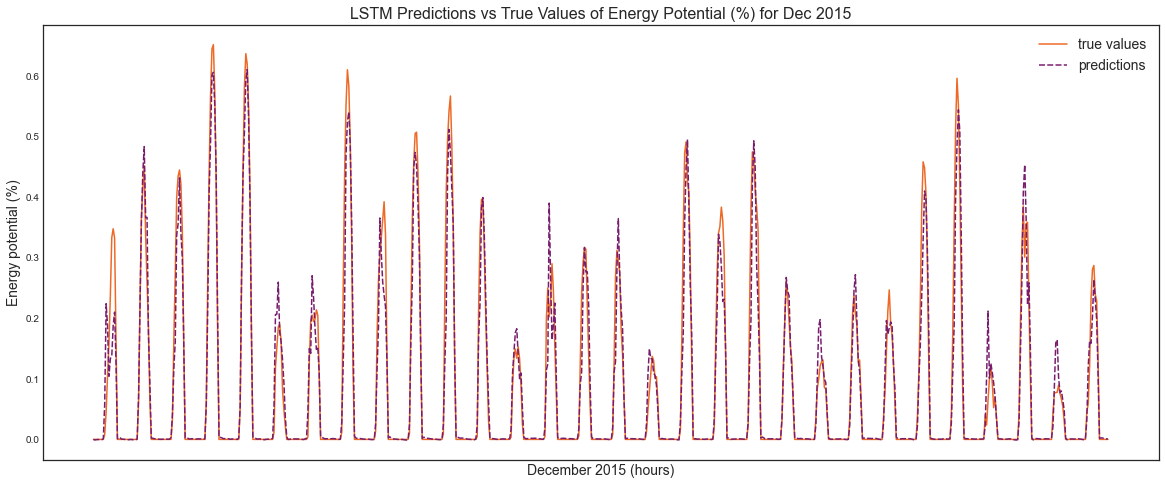

In [25]:
#create dataframe for visualization
lstm_viz = pd.DataFrame(zip(list(y_test_rnn), list(np.squeeze(y_pred_test_lstm))), columns = ['true values', 'prediction'])
# visualise
predictions_viz(lstm_viz[-30*24:],"LSTM Predictions vs True Values of Energy Potential (%) for Dec 2015")

### Conclusion

Considering all models ran, linear regression, random forest, k neighbours and XGBoost did not do better than the baseline. In other words, we are better off predicting the average solar energy potential than using any of these listed models to predict. 

Only FB prophet, and neural networks did better than other models to accurately predict solar energy potential.


### References

<ins>RNN</ins>

https://www.tensorflow.org/guide/keras/rnn

https://medium.com/analytics-vidhya/recurrent-neural-networks-rnns-and-time-series-forecasting-d9ea933426b3

https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru

<ins>LSTM</ins>

https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/